In [2]:
import geopandas as gpd
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

/bsuhome/yavarpourmohamad/miniforge3/envs/ML/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

newCmapp = {
    'Power': '#a6cee3',
    'Equipment': '#1f78b4',
    'Recreation': '#b2df8a',
    'Debris': '#33a02c',
    'Arson': '#fb9a99',
    'Misuse by minor': '#e31a1c',
    'Natural': '#fdbf6f',
    'Firearms': '#ff7f00',
    'Fireworks': '#cab2d6',
    'Railroad': '#ffff99',
    'Smoking': '#b15928'
}
causes = ['Natural', 'Debris', 'Fireworks', 'Arson', 'Recreation', 'Smoking',
          'Equipment', 'Power', 'Misuse by minor', 'Firearms', 'Railroad']
states = gpd.read_file(filename = '/bsuhome/yavarpourmohamad/scratch/FPA_FOD_Paper/Grid_variable_map/States/cb_2018_us_state_500k.shp')
states = states[['STUSPS', 'NAME', 'geometry']]
states = states.to_crs('EPSG:4326')
sts = ['WA', 'OR', 'CA', 'ID', 'NV', 'MT', 'WY', 'UT', 'AZ', 'CO', 'NM']
sts.sort()
states = states.loc[states['STUSPS'].isin(sts)]
csv_list = glob.glob(pathname='/bsuhome/yavarpourmohamad/scratch/Dissertation/Cause_specific/Time_series_grid/yearly/ts_data_cause20*.csv')
csv_list.sort()

In [3]:
first = True
for csv in tqdm(csv_list[:]):
    temp = pd.read_csv(filepath_or_buffer=csv, sep=',', low_memory=False)
    temp['date'] = pd.to_datetime(temp['date'])
    temp['season'] = temp['date'].dt.month.apply(lambda x: 'Dec-Feb' if x in [12, 1, 2] else 
                                                            'Mar-May' if x in [3, 4, 5] else
                                                            'Jun-Aug' if x in [6, 7, 8] else
                                                            'Sep-Nov')
    temp = temp.groupby(by=['season'])[causes].sum().reset_index()
   
    if first:
        total = temp.copy(deep=True)
        first = False
    else:
        total[causes] = temp[causes] + total[causes]
total[causes] = total[causes]/5

# Line Chart

In [7]:
first = True
for csv in tqdm(csv_list[:]):
    temp = pd.read_csv(filepath_or_buffer=csv, sep=',', low_memory=False)
    temp['date'] = pd.to_datetime(temp['date'])
    temp['season'] = temp['date'].dt.strftime('%b')
    temp = temp.groupby(by=['STATE', 'season'])[causes].sum().reset_index()
    if first:
        total = temp.copy(deep=True)
        first = False
    else:
        total[causes] = temp[causes] + total[causes]
total[causes] = total[causes]/5

100%|██████████| 5/5 [33:31<00:00, 402.35s/it]


In [8]:
plt_dt = total.melt(id_vars=['STATE', 'season'], value_vars=causes, value_name='counts', var_name='causes')
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt_dt['season'] = pd.Categorical(plt_dt['season'], categories=month_order, ordered=True)
plt_dt = plt_dt.sort_values('season')

fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=False, figsize=(5, 2))
# ax = axes.flatten()
temp = plt_dt[plt_dt['STATE'] == 'AZ']
sns.lineplot(data=temp,
                x='season',
                y='counts',
                hue='causes',
                ax=axes,
                palette=newCmapp,
                legend=True)
handles, labels = axes.get_legend_handles_labels()
plt.close()

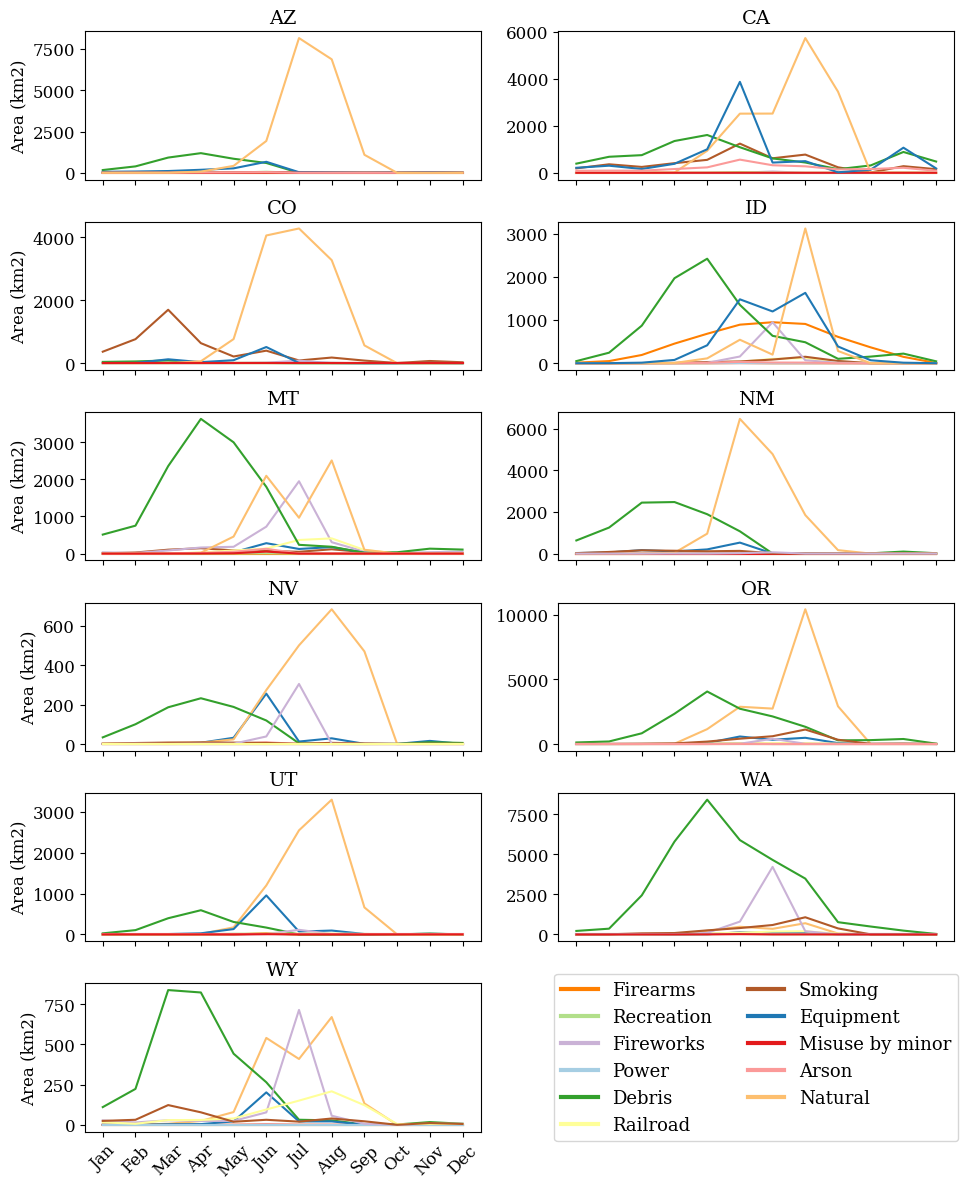

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=6, sharex=True, sharey=False, figsize=(5*2, 2*6))
ax = axes.flatten()
for i, st in enumerate(sts[:]):
    temp = plt_dt[plt_dt['STATE'] == st]
    sns.lineplot(data=temp,
                 x='season',
                 y='counts',
                 hue='causes',
                 ax=ax[i],
                 palette=newCmapp,
                 legend=False)
    
    ax[i].set_title(label=st, fontsize=14)
    ax[i].set_xlabel('')
    ax[i].set_ylabel(ylabel='Pixel day', fontsize=12)
    ax[i].tick_params(axis='both', labelsize=12)
    ax[i].tick_params(axis='x', rotation=45)
    if i % 2 == 1:
        ax[i].set_ylabel('')
    
ax[-1].axis('off')
legend = ax[-1].legend(handles, labels, loc='center', ncol=2, fontsize=13)
for line in legend.get_lines():
    line.set_linewidth(3)

plt.tight_layout()
plt.show()